# Analysing the Petition for a General Election

2024 general election results where downloaded from [here](https://commonslibrary.parliament.uk/research-briefings/cbp-10009/) on 29 November 2024. Petition results were downloaded using the following command on 29 November 2024:

```shell
curl https://petition.parliament.uk/petitions/700143.json | jq > data/election-petition-results.json
```

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import find_dotenv

ROOT_DIR = Path(find_dotenv("pyproject.toml")).parent
DATA_DIR = ROOT_DIR / "data"
ELECTION_RESULTS_PATH = DATA_DIR / "election-petition" / "HoC-GE2024-results-by-candidate.csv"
PETITION_RESULTS_PATH = DATA_DIR / "election-petition" / "election-petition-results.json"

TOP_PARTIES = [
    "Conservative",
    "Labour",
    "Liberal Democrat",
    "Reform UK",
    "Green",
    "Scottish National Party",
    "Plaid Cymru",
    "Independent",
]

PARTY_COLOURS = {
    "Conservative": "#0087DC",
    "Labour": "#E4003B",
    "Liberal Democrat": "#FAA61A",
    "Reform UK": "#12B6CF",
    "Green": "#02A95B",
    "Scottish National Party": "#FDF38E",
    "Plaid Cymru": "#005B54",
    "Independent": "grey",
}

sns.set_style("ticks")
sns.set_palette(PARTY_COLOURS.values())

In [2]:
with PETITION_RESULTS_PATH.open("r", encoding="utf-8") as f:
    petition_results_json = json.load(f)

petition_results_df = (
    pd.DataFrame.from_records(
        petition_results_json["data"]["attributes"]["signatures_by_constituency"],
        exclude=["name", "mp"],
    )
    .rename(columns={"ons_code": "ons_id"})
)

df = (
    pd.read_csv(
        ELECTION_RESULTS_PATH,
        header=0,
        usecols=[
            "ONS ID",
            "Constituency name",
            "Region name",
            "Party name",
            "Votes",
            "Share",
        ]
    )
    .rename(columns={
        "ONS ID": "ons_id",
        "Constituency name": "constituency",
        "Region name": "region",
        "Party name": "party",
        "Votes": "votes",
        "Share": "share",
    })
    .replace({"party": {"Labour and Co-operative": "Labour"}})  # Labour in Wales
    .merge(petition_results_df, on="ons_id", how="left")
)

df = (
    df
    .join(df.groupby("ons_id")["votes"].sum().rename("total_votes"), how="left", on="ons_id")
    .assign(signatures_per_vote=lambda x: x["signature_count"] / x["total_votes"])
)

df = (
    df.merge(
        df
        .sort_values("votes", ascending=False)
        .groupby("ons_id")
        .first()[["party", "votes"]]
        .assign(winner=True)
        .reset_index(),
        on=["ons_id", "party", "votes"],
        how="left",
    )
    .fillna({"winner": False})
)

print(f'Total petition signatures: {petition_results_json["data"]["attributes"]["signature_count"]:,d}')
print(f'Total petition signatures from per-consituency counts: {df.groupby("ons_id")["signature_count"].max().sum():,d}')

Total petition signatures: 2,886,188
Total petition signatures from per-consituency counts: 2,831,513


/tmp/ipykernel_59936/2971000648.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"winner": False})


In [3]:
df

ons_id      constituency                    region             party  \
0     W07000081  Aberafan Maesteg                     Wales    Heritage Party   
1     W07000081  Aberafan Maesteg                     Wales       Independent   
2     W07000081  Aberafan Maesteg                     Wales  Liberal Democrat   
3     W07000081  Aberafan Maesteg                     Wales             Green   
4     W07000081  Aberafan Maesteg                     Wales      Conservative   
...         ...               ...                       ...               ...   
4510  E14001605        York Outer  Yorkshire and The Humber             Green   
4511  E14001605        York Outer  Yorkshire and The Humber  Liberal Democrat   
4512  E14001605        York Outer  Yorkshire and The Humber         Reform UK   
4513  E14001605        York Outer  Yorkshire and The Humber      Conservative   
4514  E14001605        York Outer  Yorkshire and The Humber            Labour   

      votes     share  signature_count  total_votes  signatures_per_vote  \
0       183  0.005118             3444        35755             0.096322   
1       618  0.017284             3444        35755             0.096322   
2       916  0.025619             3444        35755             0.096322   
3      1094  0.030597             3444        35755             0.096322   
4      2903  0.081191             3444        35755             0.096322   
...     ...       ...              ...          ...                  ...   
4510   2212  0.043283             4135        51106             0.080910   
4511   5496  0.107541             4135        51106             0.080910   
4512   5912  0.115681             4135        51106             0.080910   
4513  13770  0.269440             4135        51106             0.080910   
4514  23161  0.453195             4135        51106             0.080910   

      winner  
0      False  
1      False  
2      False  
3      False  
4      False  
...      ...  
4510   False  
4511   False  
4512   False  
4513   False  
4514    True  

[4515 rows x 10 columns]

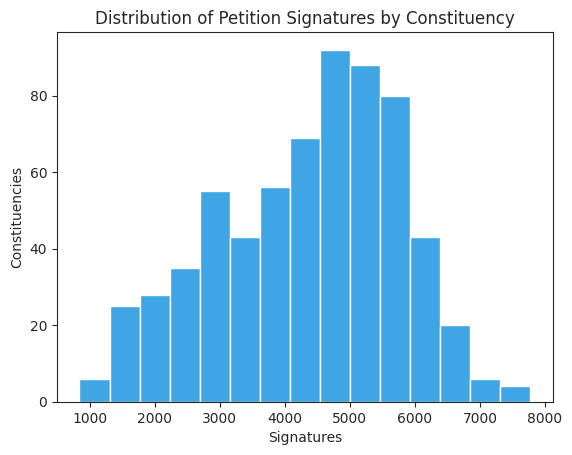

In [4]:
ax = sns.histplot(
    df.groupby("ons_id")["signature_count"].max()
)
ax.set(xlabel="Signatures", ylabel="Constituencies", title="Distribution of Petition Signatures by Constituency")
plt.show()

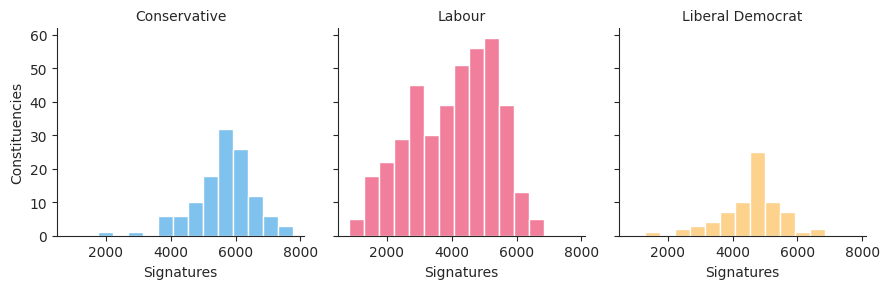

In [5]:
top_n = 3
g = sns.displot(
    df[df["winner"] & (df["party"].isin(TOP_PARTIES[:top_n]))],
    kind="hist",
    x="signature_count",
    hue="party",
    hue_order=TOP_PARTIES[:top_n],
    col="party",
    col_order=TOP_PARTIES[:top_n],
    height=3,
    legend=False,
).set_titles("{col_name}").set_axis_labels("Signatures", "Constituencies")

plt.show()

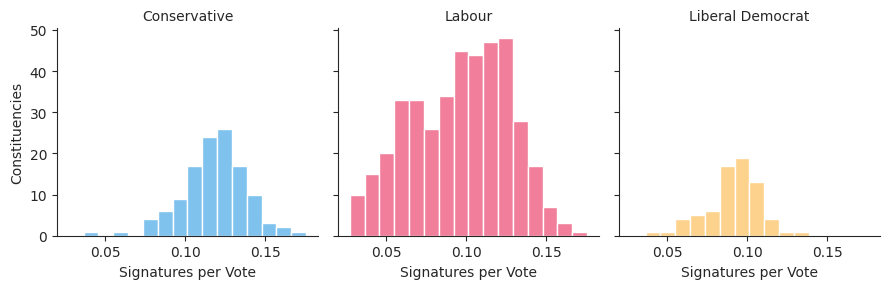

In [6]:
top_n = 3
g = sns.displot(
    df[df["winner"] & (df["party"].isin(TOP_PARTIES[:top_n]))],
    kind="hist",
    x="signatures_per_vote",
    hue="party",
    hue_order=TOP_PARTIES[:top_n],
    col="party",
    col_order=TOP_PARTIES[:top_n],
    height=3,
    legend=False,
).set_titles("{col_name}").set_axis_labels("Signatures per Vote", "Constituencies")

plt.show()

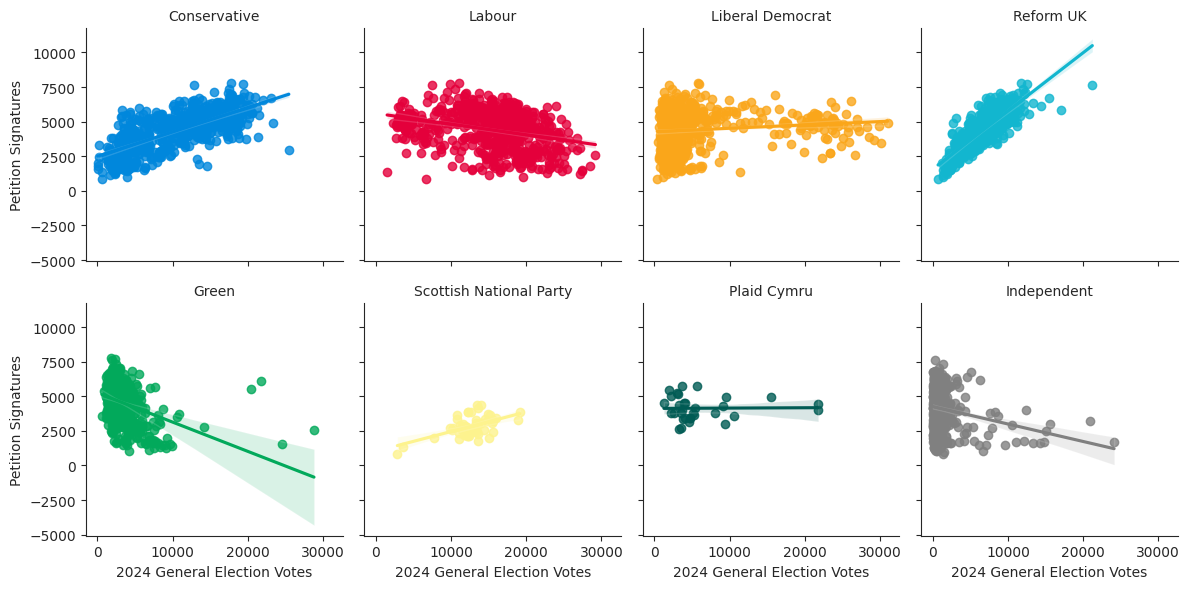

In [7]:
sns.lmplot(
    df[df["party"].isin(TOP_PARTIES)],
    x="votes",
    y="signature_count",
    col="party",
    col_wrap=4,
    col_order=TOP_PARTIES,
    hue="party",
    hue_order=TOP_PARTIES,
    height=3,
).set_titles("{col_name}").set_axis_labels("2024 General Election Votes", "Petition Signatures")

plt.show()

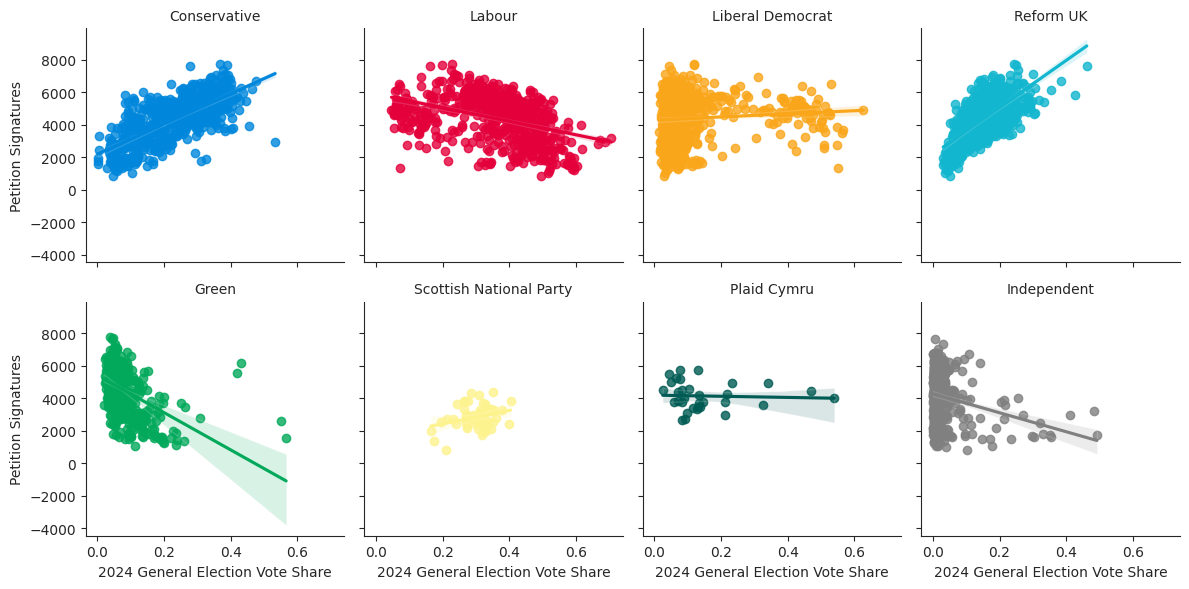

In [8]:
sns.lmplot(
    df[df["party"].isin(TOP_PARTIES)],
    x="share",
    y="signature_count",
    col="party",
    col_wrap=4,
    col_order=TOP_PARTIES,
    hue="party",
    hue_order=TOP_PARTIES,
    height=3,
).set_titles("{col_name}").set_axis_labels("2024 General Election Vote Share", "Petition Signatures")

plt.show()

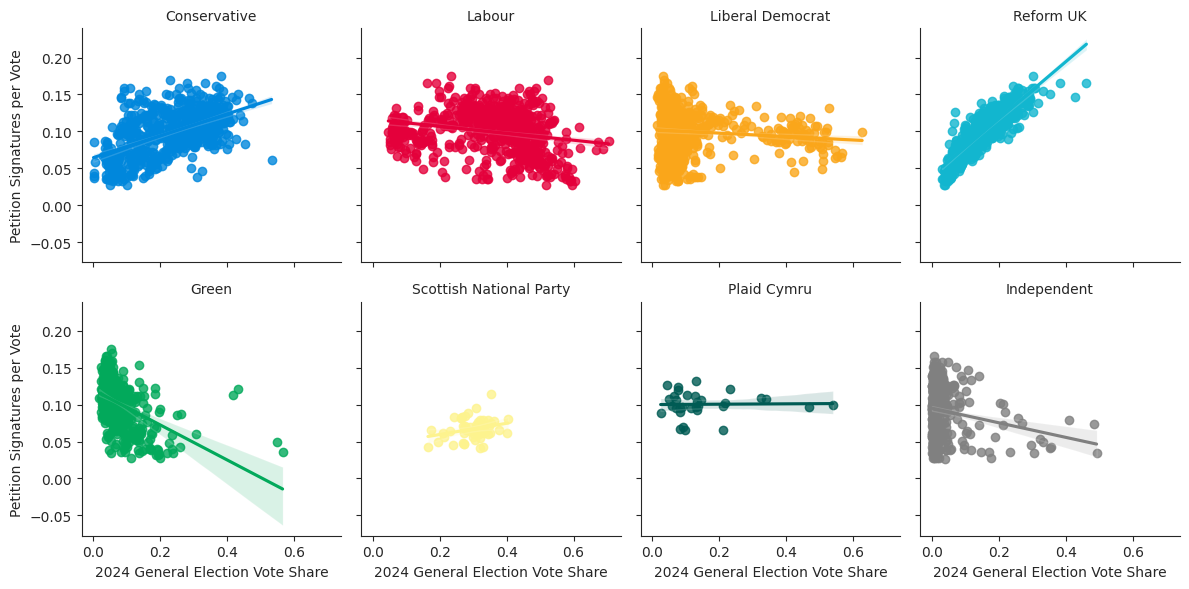

In [9]:
sns.lmplot(
    df[df["party"].isin(TOP_PARTIES)],
    x="share",
    y="signatures_per_vote",
    col="party",
    col_wrap=4,
    col_order=TOP_PARTIES,
    hue="party",
    hue_order=TOP_PARTIES,
    height=3,
).set_titles("{col_name}").set_axis_labels("2024 General Election Vote Share", "Petition Signatures per Vote")

plt.show()